# Import necessary libraries

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm 
from skimage.transform import resize
from scipy.ndimage import label
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Dataset

In [2]:
from zipfile import ZipFile
with ZipFile("/kaggle/input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("/kaggle/input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")

In [3]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)

# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

# Preprocessing

In [4]:
def get_ids(path):
    """Get the IDs of the images in the given path."""
    return next(os.walk(path))[1]

# Train & Test ids
train_ids = get_ids(TRAIN_PATH)
test_ids = get_ids(TEST_PATH)

## Load & Resize Image and mask

In [5]:
def resize_images_and_masks(train_ids):
    X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = os.path.join(TRAIN_PATH, id_)
        img = imread(os.path.join(path, 'images', f'{id_}.png'))[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
            mask_ = imread(os.path.join(path, 'masks', mask_file))
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        y[n] = mask
    return X, y

# Resize real image & Mask
X, y = resize_images_and_masks(train_ids)

Resizing training images and masks


100%|██████████| 670/670 [04:01<00:00,  2.78it/s]


In [6]:
def resize_test_images(test_ids):
    test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    
    print('Resizing test images')
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = os.path.join(TEST_PATH, id_)
        img = imread(os.path.join(path, 'images', f'{id_}.png'))[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        test_images[n] = img
    return test_images, sizes_test

# Resize Test image
test_images, sizes_test = resize_test_images(test_ids)

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 47.78it/s]


## Split train and Validations Set

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_validations shape: {X_val.shape}")
print(f"y_validations shape: {y_val.shape}")

print(f"Test image shape: {test_images.shape}")
print(f"Test Size: {len(sizes_test)}")

X_train shape: (448, 128, 128, 3)
y_train shape: (448, 128, 128, 1)
X_validations shape: (222, 128, 128, 3)
y_validations shape: (222, 128, 128, 1)
Test image shape: (65, 128, 128, 3)
Test Size: 65


## Plot the sample real and Mask Image

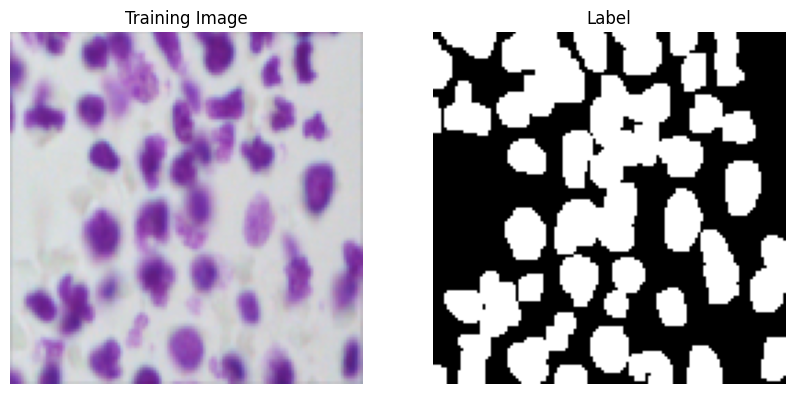

In [8]:
# Choose a random index for the image
image_x = random.randint(0, len(X_train) - 1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5))  # 1 row, 2 columns

# Display the training image
axes[0].imshow(np.squeeze(X_train[image_x]), cmap='gray')  # Use squeeze to remove single-dimensional entries
axes[0].axis("off")  # Hide the axis
axes[0].set_title("Training Image")

# Display the corresponding label
axes[1].imshow(np.squeeze(y_train[image_x]), cmap='gray')  # Use squeeze to remove single-dimensional entries
axes[1].axis("off")  # Hide the axis
axes[1].set_title("Label")

# Show the plot
plt.show()

# Build the Unet model

In [9]:
# Define image dimensions and number of channels
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
num_classes = 1

# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(r5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

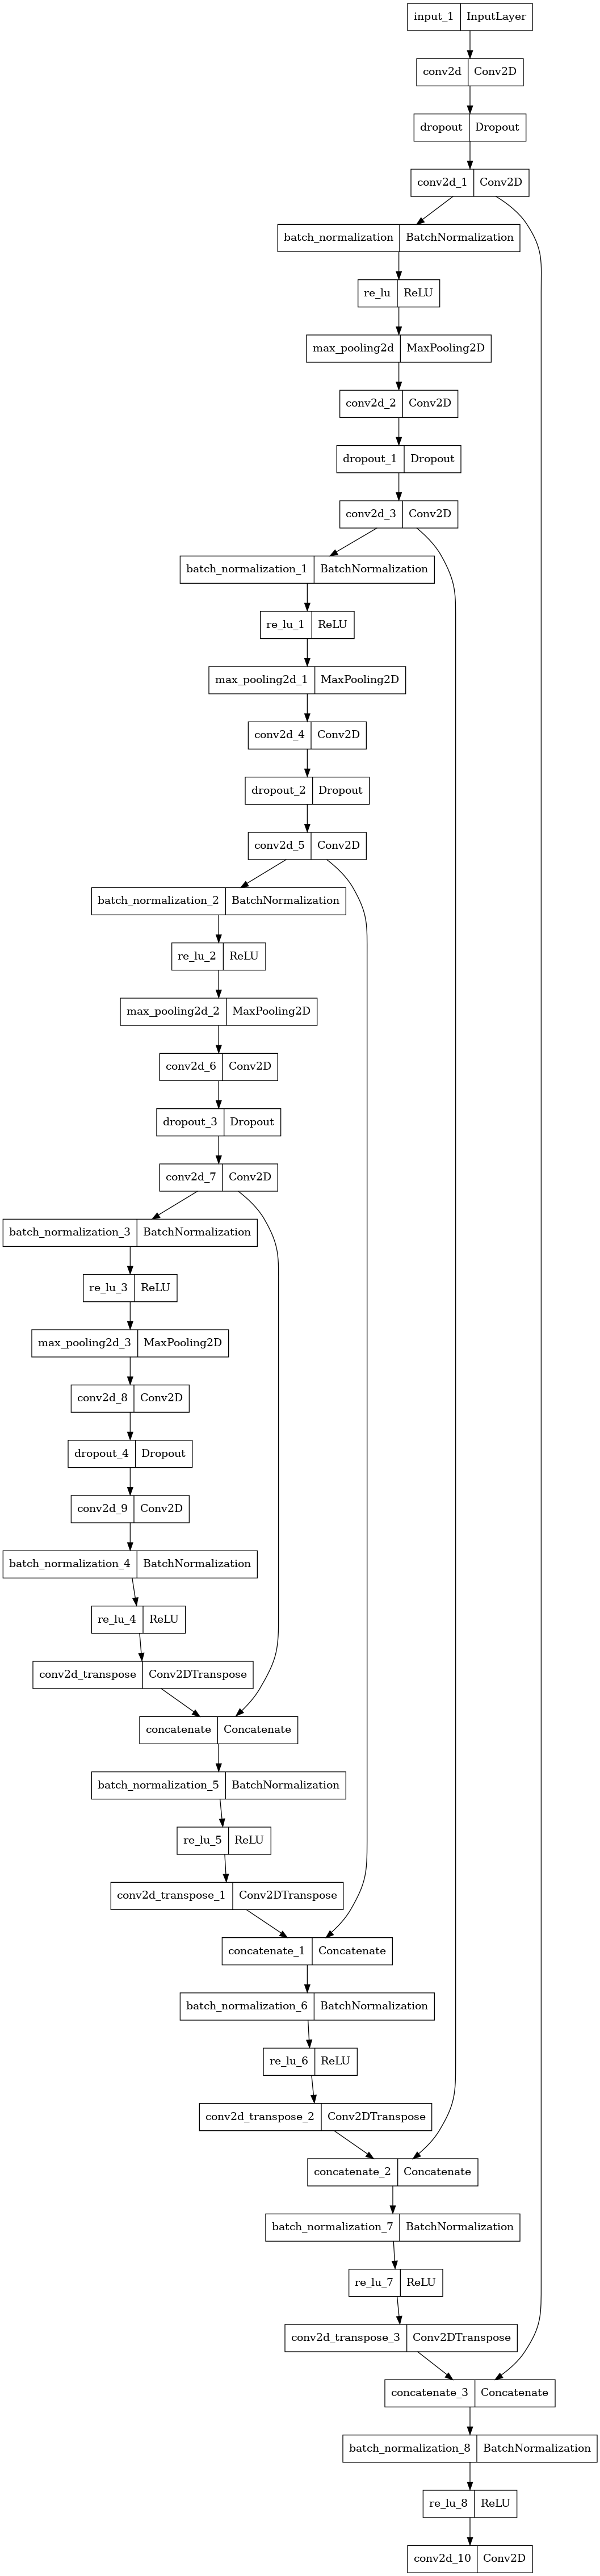

In [10]:
tf.keras.utils.plot_model(model, "model.png")

# Train the model

## Compile the model

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=35, callbacks=callbacks)

Epoch 1/35


2024-06-11 10:59:33.940313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 [==============================] - 14s 48ms/step - loss: 0.5511 - accuracy: 0.7967 - val_loss: 0.6642 - val_accuracy: 0.7886
Epoch 2/35
28/28 [==============================] - 1s 28ms/step - loss: 0.3304 - accuracy: 0.9036 - val_loss: 0.4504 - val_accuracy: 0.9023
Epoch 3/35
28/28 [==============================] - 1s 27ms/step - loss: 0.2606 - accuracy: 0.9182 - val_loss: 0.3159 - val_accuracy: 0.9239
Epoch 4/35
28/28 [==============================] - 1s 28ms/step - loss: 0.1982 - accuracy: 0.9407 - val_loss: 0.2384 - val_accuracy: 0.9369
Epoch 5/35
28/28 [==============================] - 1s 27ms/step - loss: 0.1673 - accuracy: 0.9474 - val_loss: 0.1821 - val_accuracy: 0.9509
Epoch 6/35
28/28 [==============================] - 1s 28ms/step - loss: 0.1558 - accuracy: 0.9496 - val_loss: 0.1553 - val_accuracy: 0.9527
Epoch 7/35
28/28 [==============================] - 1s 27ms/step - loss: 0.1376 - accuracy: 0.9537 - val_loss: 0.1381 - val_accuracy: 0.9550
Epoch 8/35
28/28 [=====

# Model Evaluations

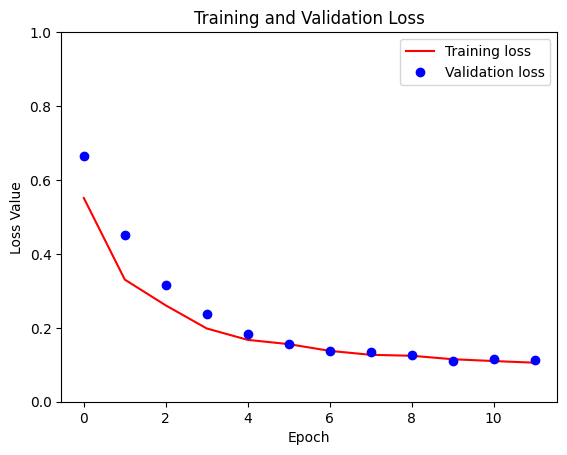

In [13]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

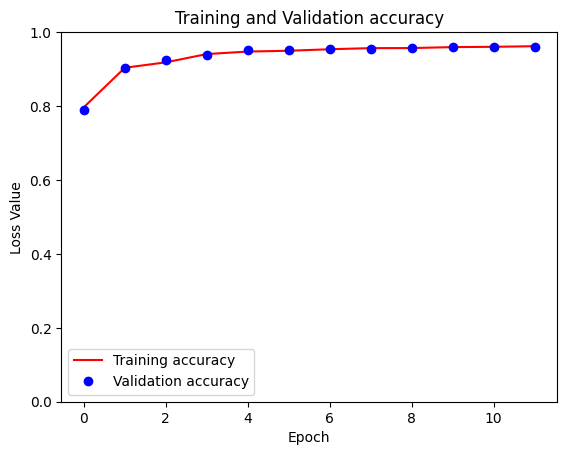

In [14]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Save and Load the model

In [15]:
from keras.models import save_model, load_model

# Save the model
model.save("model.h5")

# Load the model
model = load_model("model.h5")

# Predictions

In [16]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]

In [17]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 [==============================] - 0s 373ms/step


In [18]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

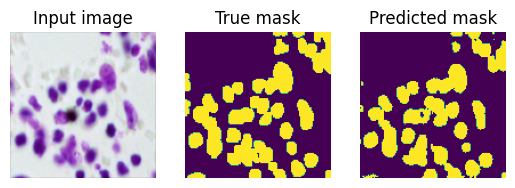

In [19]:
def display(display_list):
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
display([sample_image, sample_mask,predicted_mask])

# Submission

1/1 [==============================] - 0s 21ms/step


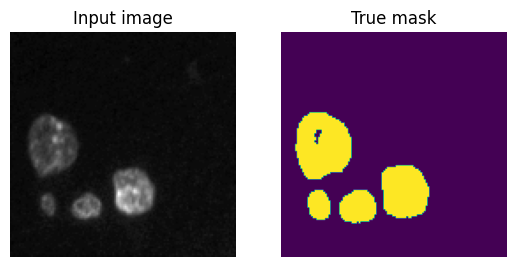

In [20]:
i = random.randint(0, len(test_images))
test_image = test_images[i]

prediction = model.predict(test_image[tf.newaxis, ...])[0]

generated_mask = (prediction > 0.5).astype(np.uint8)

    
display([test_image, generated_mask])

In [21]:
class ImageSegmentationEncoder:
    def __init__(self, model, test_images, sizes_test):
        self.model = model
        self.test_images = test_images
        self.sizes_test = sizes_test

    def rle_encoding(self, x):
        dots = np.where(x.T.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev + 1):
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths

    def prob_to_rles(self, x, cutoff=0.5):
        lab_img, _ = label(x > cutoff)  # Extract the labeled image from the tuple
        for i in range(1, lab_img.max() + 1):
            yield self.rle_encoding(lab_img == i)

    def predict_and_encode(self):
        # Predict on test images
        preds_test = self.model.predict(self.test_images, verbose=1)

        # Upsample the predicted masks to the original sizes
        preds_test_upsampled = [resize(np.squeeze(preds_test[i]),
                                       (self.sizes_test[i][0], self.sizes_test[i][1]),
                                       mode='constant', preserve_range=True)
                                for i in range(len(preds_test))]

        # Run-length encode the predictions
        rles = []
        for i in range(len(preds_test_upsampled)):
            rle = list(self.prob_to_rles(preds_test_upsampled[i]))
            rles.extend(rle)

        return rles

    def create_submission(self, test_ids, output_filename):
        # Generate submission DataFrame
        new_test_ids = []
        rles = self.predict_and_encode()
        for n, id_ in enumerate(test_ids):
            new_test_ids.extend([id_] * len(rles[n]))

        submission_df = pd.DataFrame()
        submission_df['ImageId'] = new_test_ids
        submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

        # Write submission to CSV
        submission_df.to_csv(output_filename, index=False)
        print("Submission file created successfully!")


# Instantiate the ImageSegmentationEncoder class
segmentation_encoder = ImageSegmentationEncoder(model, test_images, sizes_test)

# Provide test_ids and output filename
test_ids = os.listdir(TEST_PATH)  # Your test image IDs
output_filename = 'sub-dsbowl2018-1.csv'

# Create submission file
segmentation_encoder.create_submission(test_ids, output_filename)

3/3 [==============================] - 0s 7ms/step
Submission file created successfully!
